<a href="https://colab.research.google.com/github/Zirwa26/ai_visualization/blob/main/CNN_ALEXNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!curl -L -o tiny-imagenet-200.zip https://cs231n.stanford.edu/tiny-imagenet-200.zip





  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  29.7M      0  0:00:07  0:00:07 --:--:-- 22.2M


In [15]:
if not os.path.exists('tiny-imagenet-200'):
    !unzip -q tiny-imagenet-200.zip


In [16]:
data_dir = "/content/tiny-imagenet-200"


In [17]:
import os
import shutil
from pathlib import Path

def restructure_val_folder(data_dir):
    val_dir = Path(data_dir) / 'val'
    images_dir = val_dir / 'images'
    ann_file = val_dir / 'val_annotations.txt'

    with open(ann_file, 'r') as f:
        for line in f.readlines():
            img_name, class_name = line.split('\t')[:2]
            class_dir = val_dir / class_name
            class_dir.mkdir(exist_ok=True)
            shutil.move(str(images_dir / img_name), str(class_dir / img_name))

    shutil.rmtree(images_dir)

# Set path and restructure val set if needed
data_dir = "/content/tiny-imagenet-200"
if os.path.exists(os.path.join(data_dir, 'val', 'images')):
    restructure_val_folder(data_dir)


In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 128
input_size = 64

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AlexNetTiny(nn.Module):
    def __init__(self, num_classes=200):
        super(AlexNetTiny, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # 🧠 Dynamically compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 64, 64)  # (N, C, H, W)
            dummy_out = self.features(dummy)
            self.flattened_size = dummy_out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [20]:
def compute_top5_accuracy(model, dataloader):
    model.eval()
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get top-5 predictions
            _, top5_preds = outputs.topk(5, dim=1)  # shape: [batch, 5]

            # Compare with true labels
            correct = top5_preds.eq(labels.view(-1, 1).expand_as(top5_preds))  # shape: [batch, 5]
            top5_correct += correct.sum().item()
            total += labels.size(0)

    top5_acc = top5_correct / total
    print(f"✅ Top-5 Accuracy: {top5_acc * 100:.2f}%")
    return top5_acc


In [21]:
import matplotlib.pyplot as plt

def visualize_conv1_weights(model):
    # Extract Conv1 weights (shape: [out_channels, in_channels, H, W])
    weights = model.features[0].weight.data.clone().cpu()

    num_filters = weights.shape[0]  # e.g., 64 or 96
    plt.figure(figsize=(16, 8))

    for i in range(min(num_filters, 8)):  # visualize first 8 filters
        # Convert 3xHxW weights into HxW by averaging channels for visualization
        weight_img = weights[i].mean(dim=0)  # shape: HxW

        plt.subplot(2, 4, i+1)
        plt.imshow(weight_img, cmap='gray')
        plt.title(f"Filter {i}")
        plt.axis('off')

    plt.suptitle("Conv1 Filter Weights (Averaged over RGB Channels)")
    plt.tight_layout()
    plt.show()


In [24]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetTiny(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def evaluate(model):
    model.eval()
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = outputs.topk(5, dim=1, largest=True, sorted=True)
            correct1 += (preds[:, 0] == labels).sum().item()
            correct5 += sum([labels[i] in preds[i] for i in range(labels.size(0))])
            total += labels.size(0)

    loss = val_loss / total
    top1_acc = 100 * correct1 / total
    top5_acc = 100 * correct5 / total
    print(f"Val   Loss: {loss:.4f} | Top-1 Acc: {top1_acc:.2f}% | Top-5 Acc: {top5_acc:.2f}%")


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct1 = 0
        correct5 = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

            # 🔹 Top-1 and Top-5 accuracy
            _, preds = outputs.topk(5, dim=1, largest=True, sorted=True)
            correct1 += (preds[:, 0] == labels).sum().item()
            correct5 += sum([labels[i] in preds[i] for i in range(labels.size(0))])

        scheduler.step()

        epoch_loss = running_loss / total
        top1_acc = 100 * correct1 / total
        top5_acc = 100 * correct5 / total

        print(f"Train Loss: {epoch_loss:.4f} | Top-1 Acc: {top1_acc:.2f}% | Top-5 Acc: {top5_acc:.2f}%")

        evaluate(model)

train_model(model, criterion, optimizer, scheduler, num_epochs=10)



Epoch 1/10


100%|██████████| 782/782 [01:20<00:00,  9.73it/s]

Train Loss: 5.2988 | Top-1 Acc: 0.45% | Top-5 Acc: 2.31%


Val   Loss: 5.2973 | Top-1 Acc: 0.76% | Top-5 Acc: 2.96%

Epoch 2/10


100%|██████████| 782/782 [01:19<00:00,  9.83it/s]

Train Loss: 5.2675 | Top-1 Acc: 0.62% | Top-5 Acc: 3.08%


Val   Loss: 5.1997 | Top-1 Acc: 1.02% | Top-5 Acc: 5.11%

Epoch 3/10


100%|██████████| 782/782 [01:19<00:00,  9.86it/s]

Train Loss: 5.1722 | Top-1 Acc: 1.07% | Top-5 Acc: 4.96%


Val   Loss: 5.0770 | Top-1 Acc: 1.26% | Top-5 Acc: 6.48%

Epoch 4/10


100%|██████████| 782/782 [01:18<00:00,  9.97it/s]

Train Loss: 5.0318 | Top-1 Acc: 1.83% | Top-5 Acc: 7.85%


Val   Loss: 4.9073 | Top-1 Acc: 2.56% | Top-5 Acc: 10.41%

Epoch 5/10


100%|██████████| 782/782 [01:20<00:00,  9.76it/s]

Train Loss: 4.9258 | Top-1 Acc: 2.52% | Top-5 Acc: 10.57%


Val   Loss: 4.8734 | Top-1 Acc: 2.83% | Top-5 Acc: 11.82%

Epoch 6/10


100%|██████████| 782/782 [01:18<00:00, 10.01it/s]

Train Loss: 4.8084 | Top-1 Acc: 3.58% | Top-5 Acc: 13.52%


Val   Loss: 4.7231 | Top-1 Acc: 3.85% | Top-5 Acc: 15.14%

Epoch 7/10


100%|██████████| 782/782 [01:20<00:00,  9.76it/s]

Train Loss: 4.7593 | Top-1 Acc: 4.03% | Top-5 Acc: 14.61%


Val   Loss: 4.7049 | Top-1 Acc: 4.35% | Top-5 Acc: 15.80%

Epoch 8/10


100%|██████████| 782/782 [01:19<00:00,  9.80it/s]

Train Loss: 4.7389 | Top-1 Acc: 4.23% | Top-5 Acc: 15.03%


Val   Loss: 4.6260 | Top-1 Acc: 5.16% | Top-5 Acc: 17.55%

Epoch 9/10


100%|██████████| 782/782 [01:20<00:00,  9.75it/s]

Train Loss: 4.7156 | Top-1 Acc: 4.32% | Top-5 Acc: 15.40%


Val   Loss: 4.6151 | Top-1 Acc: 4.96% | Top-5 Acc: 17.55%

Epoch 10/10


100%|██████████| 782/782 [01:20<00:00,  9.68it/s]

Train Loss: 4.7025 | Top-1 Acc: 4.60% | Top-5 Acc: 15.85%


Val   Loss: 4.5912 | Top-1 Acc: 5.20% | Top-5 Acc: 18.35%


In [25]:
compute_top5_accuracy(model, val_loader)


✅ Top-5 Accuracy: 18.35%


0.1835

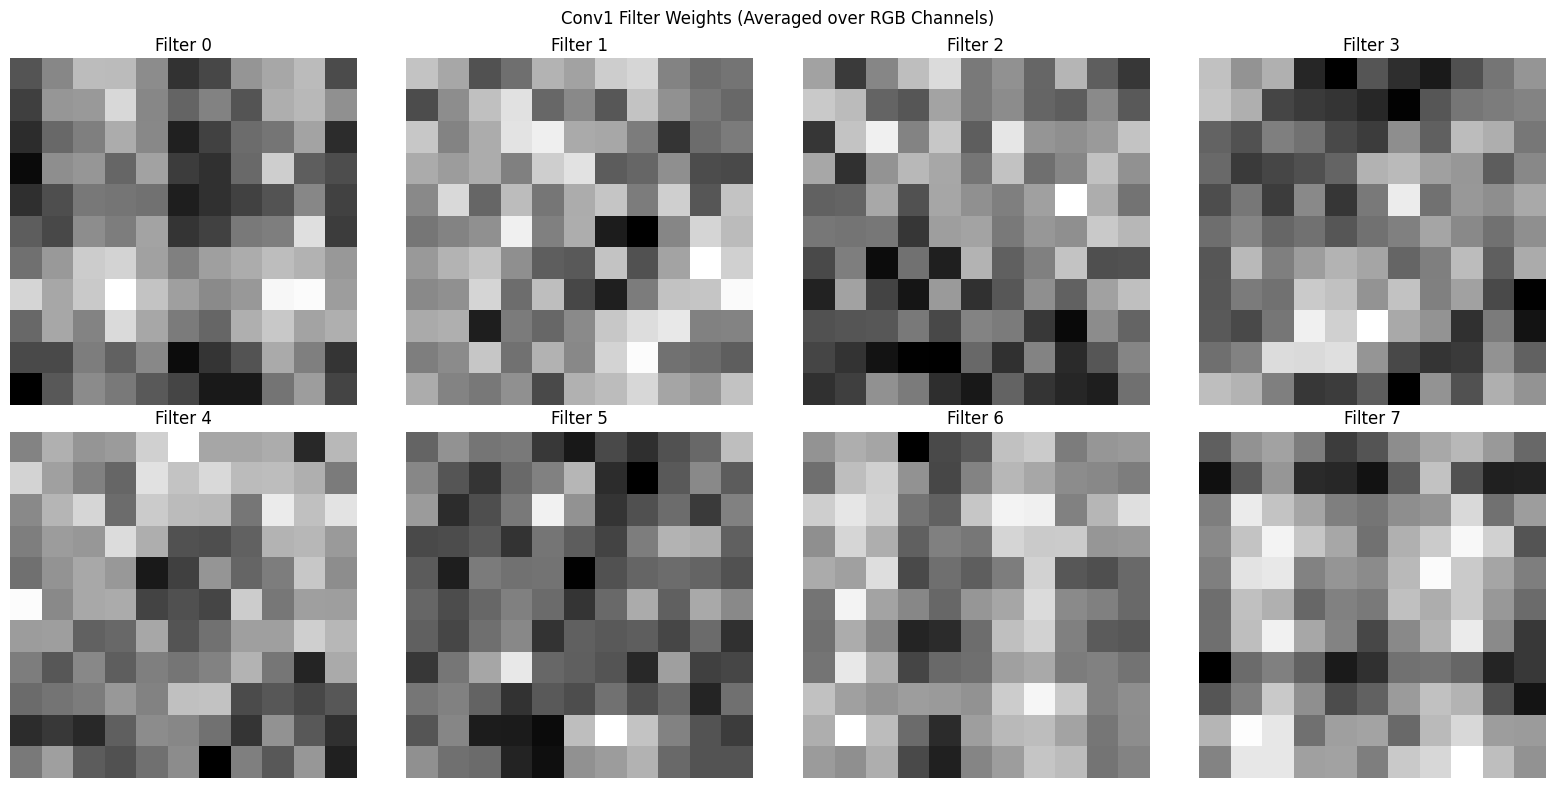

In [26]:
visualize_conv1_weights(model)


In [27]:
torch.save(model.state_dict(), "/content/drive/MyDrive/alexnet_tiny_imagenet.pth")


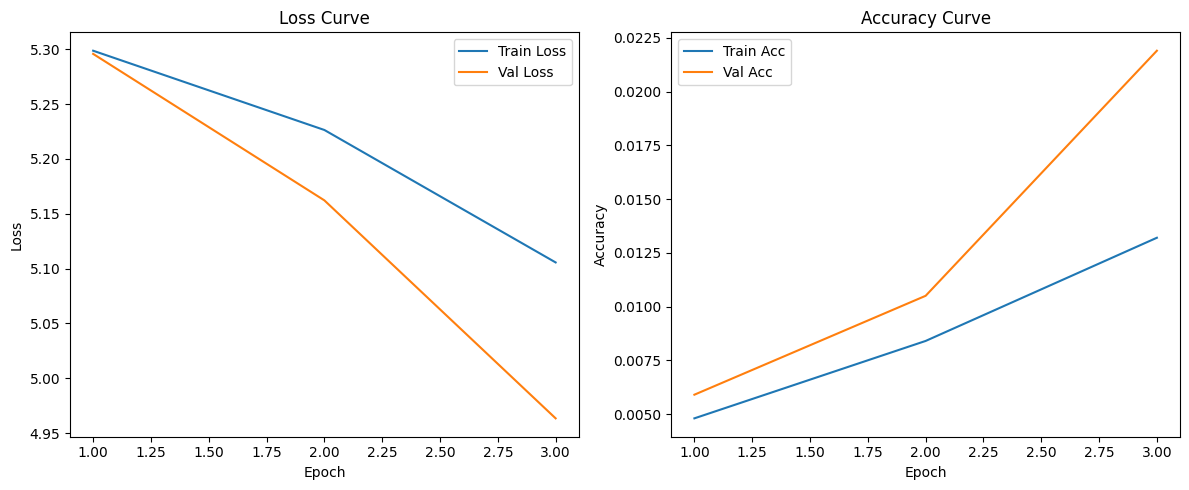

In [28]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [5.2987, 5.2264, 5.1056]
val_loss = [5.2958, 5.1622, 4.9634]
train_acc = [0.0048, 0.0084, 0.0132]
val_acc = [0.0059, 0.0105, 0.0219]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


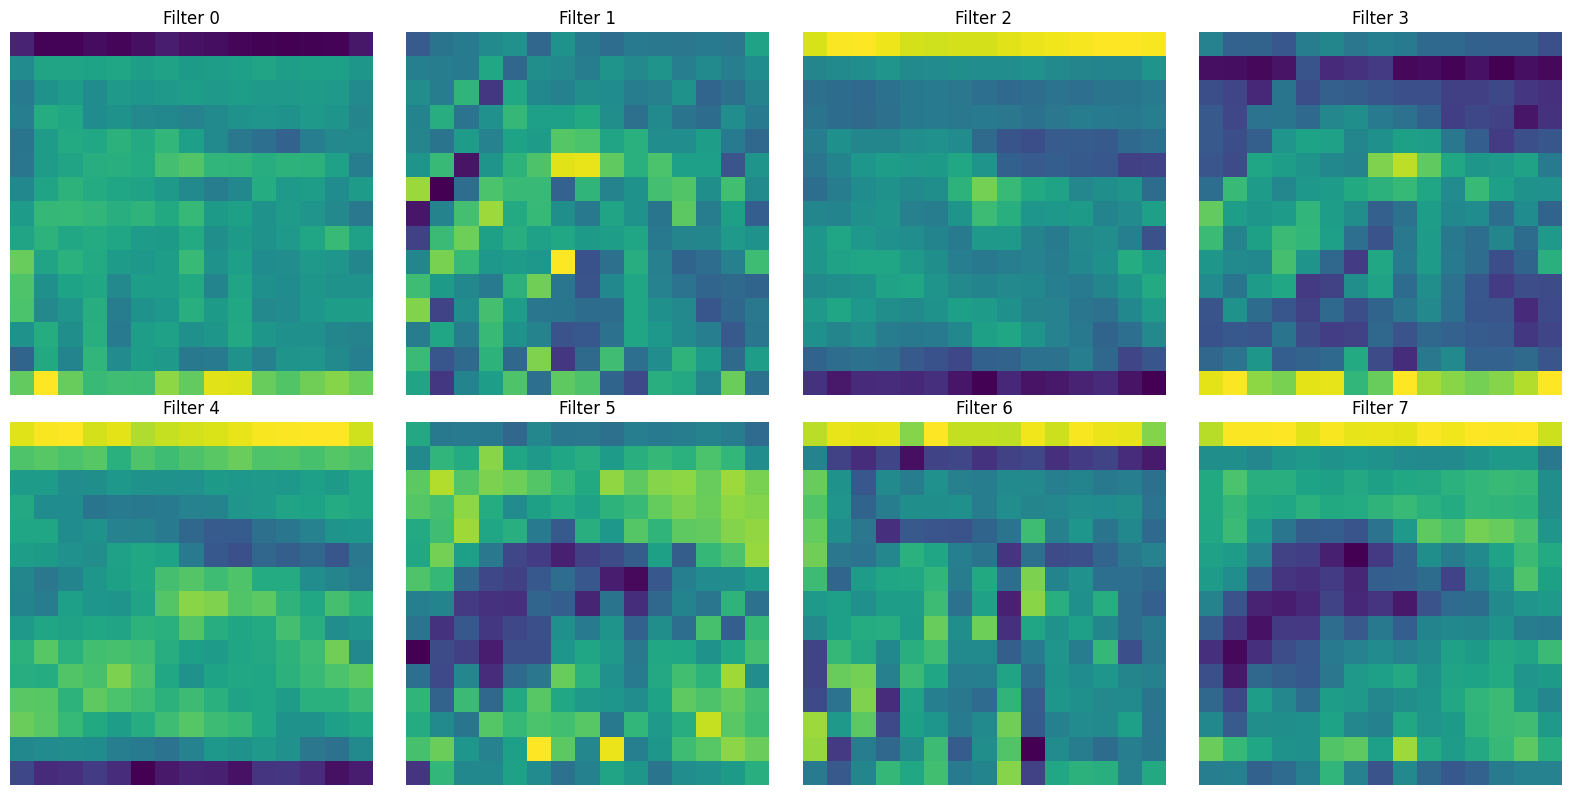

In [29]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps(model, input_tensor):
    model.eval()
    with torch.no_grad():
        # Extract features after first conv layer
        features = model.features[0](input_tensor.unsqueeze(0).to(device))
        features = features.cpu().squeeze(0)

        plt.figure(figsize=(16, 8))
        for i in range(8):
            plt.subplot(2, 4, i+1)
            plt.imshow(features[i].numpy(), cmap='viridis')
            plt.title(f'Filter {i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# 🔹 Load a sample image from val_loader
sample_img, _ = next(iter(val_loader))  # get one batch
input_tensor = sample_img[0]  # use first image in the batch

# 🔹 Visualize
visualize_feature_maps(model, input_tensor)
